In [43]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt

In [44]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]
threshold = (300, 2500)

In [45]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [46]:
def load_subject(subject, data_directory, threshold1, threshold2, merged_controls=False):
    file_suffix = 'cells_' + str(threshold1) if subject[0] == 'F' else 'cells_' + str(threshold2)
    if merged_controls:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
        if subject[0]=='B':
            df_mouse = ace.reformat_df_mouse(df=df_mouse[df_mouse[' x']>228].reset_index(drop=True))
        else:
            df_mouse = ace.reformat_df_mouse(df=df_mouse)
    else:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
        df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

In [47]:
def sum_values(subjects, groups):
    data = pd.DataFrame(columns=['subject', 'group', 'n_cells', 'energy', 'density', 'relative_density'])
    data['subject'] = [subject for subject in subjects]
    data['group'] = [utils.split_string(subject)[-1] for subject in subjects]
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        data[metric] = [dict_results_across_mice[subject][metric].sum() \
                        for subject in subjects]
    return data

In [71]:
def dataframe_areas(area, subjects, groups):
    data = pd.DataFrame(columns=['subject', 'n_cells', 'energy', 'density', 'relative_density'])
    data['subject'] = [subject for subject in subjects]
    data['group'] = [utils.split_string(subject)[-1] for subject in subjects]
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        values = []
        for subject in subjects:
            v = dict_results_across_mice[subject]
            values.append(v[v['area']==area][metric].values[0])
        data[metric] = [v for v in values]
    return data

In [84]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<alpha]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

In [176]:
def find_common_pvalues(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                      dict_results_across_mice=dict_results_across_mice, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    find_common_areas = np.unique(np.concatenate([
        df_ttest[df_ttest[col]<alpha]['area'].to_numpy() \
        for col in df_ttest.loc[:, df_ttest.columns!='area'].columns]).ravel())

    df_ttest = df_ttest.set_index('area').loc[find_common_areas]
    df_ttest.columns = [col.replace('pval_', '') for col in columns if col!='area']
    df_ttest = df_ttest.reset_index()
    return df_ttest

In [ ]:
def find_pvalues(dictionary, panel, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                      dict_results_across_mice=dict_results_across_mice, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    find_common_areas = np.unique(np.concatenate([
        df_ttest[df_ttest[col]<alpha]['area'].to_numpy() \
        for col in df_ttest.loc[:, df_ttest.columns!='area'].columns]).ravel())

    df_ttest = df_ttest.set_index('area').loc[find_common_areas]
    df_ttest.columns = [col.replace('pval_', '') for col in columns if col!='area']
    df_ttest = df_ttest.reset_index()
    return df_ttest

In [49]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres.npy', 
                                   allow_pickle=True).item()

In [50]:
subjects = list(dict_results_across_mice.keys())

In [51]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

# Creiamo tabelle con le varie misure

In [52]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [53]:
df_control_cell_count.to_csv('control_ncells.csv', index=False)
df_fam_cell_count.to_csv('fam_ncells.csv', index=False)
df_unfam_cell_count.to_csv('unfam_ncells.csv', index=False)

In [54]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='energy')

In [55]:
df_control_energy.to_csv('control_energy.csv', index=False)
df_fam_energy.to_csv('fam_energy.csv', index=False)
df_unfam_energy.to_csv('unfam_energy.csv', index=False)

In [56]:
df_control_density, df_fam_density, df_unfam_density = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='density')

In [57]:
df_control_density.to_csv('control_density.csv', index=False)
df_fam_density.to_csv('fam_density.csv', index=False)
df_unfam_density.to_csv('unfam_density.csv', index=False)

In [61]:
s_values = sum_values(subjects=subjects, groups=['Control', 'Fam', 'Unfam'])

# N cellule totali

In [19]:
df_control_cell_count.set_index('area').sum()

BL53Control    29084
F10Control     47203
BL45Control    47093
F16Control      7675
BL51Control    44173
F11Control     15406
F1Control      29195
dtype: int64

In [22]:
df_fam_cell_count.set_index('area').sum()

BL49Fam    40180
F7Fam      50726
F15Fam     28414
BL47Fam    45959
F13Fam     25668
F5Fam      26756
BL50Fam    49253
F3Fam      42793
F9Fam      67115
dtype: int64

In [23]:
df_unfam_cell_count.set_index('area').sum()

F6Unfam      175787
F8Unfam       68881
BL48Unfam     43347
F4Unfam       36382
F2Unfam       76009
BL54Unfam     25408
BL52Unfam     29065
BL46Unfam     29777
F12Unfam      41229
F14Unfam      20149
dtype: int64

## Boxplot numero totale di cellule

<AxesSubplot:xlabel='group', ylabel='n_cells'>

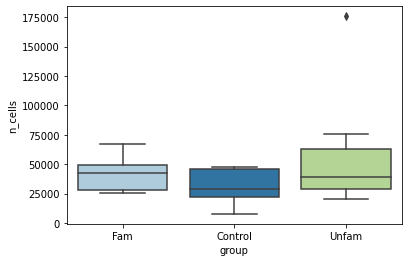

In [64]:
ax = sns.boxplot(data=s_values, y='n_cells', x='group', palette='Paired')
plt.savefig('boxplot_ncells.svg')

# Energia totale

In [26]:
df_control_energy.set_index('area').sum()

BL53Control    1.539908e+08
F10Control     4.584303e+07
BL45Control    3.190426e+08
F16Control     5.374690e+06
BL51Control    2.666885e+08
F11Control     1.250835e+07
F1Control      3.096475e+07
dtype: float64

In [28]:
df_fam_energy.set_index('area').sum()

BL49Fam    2.443567e+08
F7Fam      7.095188e+07
F15Fam     3.575699e+07
BL47Fam    2.929110e+08
F13Fam     3.365159e+07
F5Fam      3.001816e+07
BL50Fam    2.916292e+08
F3Fam      5.132347e+07
F9Fam      6.300211e+07
dtype: float64

In [27]:
df_unfam_energy.set_index('area').sum()

F6Unfam      1.553403e+08
F8Unfam      1.021610e+08
BL48Unfam    2.174758e+08
F4Unfam      4.086200e+07
F2Unfam      1.040455e+08
BL54Unfam    1.356645e+08
BL52Unfam    1.622930e+08
BL46Unfam    1.551062e+08
F12Unfam     5.370439e+07
F14Unfam     3.805825e+07
dtype: float64

## Boxplot energia

<AxesSubplot:xlabel='group', ylabel='energy'>

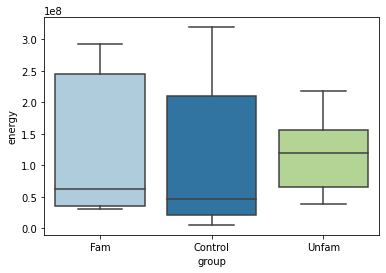

In [65]:
ax = sns.boxplot(data=s_values, y='energy', x='group', palette='Paired')
plt.savefig('boxplot_energy.svg')

# Density

In [29]:
df_control_density.set_index('area').sum()

BL53Control    22114.704779
F10Control     38745.342865
BL45Control    44277.108730
F16Control      5105.207129
BL51Control    39207.880766
F11Control     12170.159825
F1Control      27930.306564
dtype: float64

In [31]:
df_fam_energy.set_index('area').sum()

BL49Fam    2.443567e+08
F7Fam      7.095188e+07
F15Fam     3.575699e+07
BL47Fam    2.929110e+08
F13Fam     3.365159e+07
F5Fam      3.001816e+07
BL50Fam    2.916292e+08
F3Fam      5.132347e+07
F9Fam      6.300211e+07
dtype: float64

In [30]:
df_unfam_energy.set_index('area').sum()

F6Unfam      1.553403e+08
F8Unfam      1.021610e+08
BL48Unfam    2.174758e+08
F4Unfam      4.086200e+07
F2Unfam      1.040455e+08
BL54Unfam    1.356645e+08
BL52Unfam    1.622930e+08
BL46Unfam    1.551062e+08
F12Unfam     5.370439e+07
F14Unfam     3.805825e+07
dtype: float64

## Boxplot density

<AxesSubplot:xlabel='group', ylabel='density'>

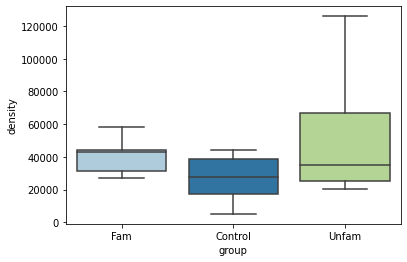

In [66]:
ax = sns.boxplot(data=s_values, y='density', x='group', palette='Paired')
plt.savefig('boxplot_density.svg')

# Boxplot aree

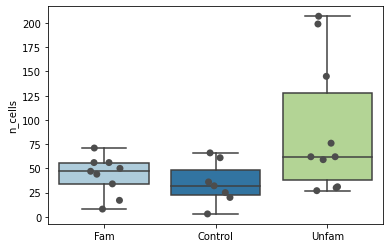

In [83]:
area = 'Supramammillary nucleus'
SuM = dataframe_areas(area=area, 
                      subjects=subjects, 
                      groups=['Control', 'Fam', 'Unfam'])
ax = sns.boxplot(data=SuM, y='n_cells', x='group', palette='Paired')
# Come aggiungere punti su boxplot
ax = sns.stripplot(data=SuM, y='n_cells', x="group", size=7, color=".3", jitter=0.15)
# remove 'group' label
ax.set_xlabel('')
plt.savefig('sum.svg')

# Plot aree significative

In [86]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups, 
                       value='n_cells', 
                       test='mannwhitneyu', 
                       alpha=0.05)

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Ventral premammillary nucleus,Periventricular hypothalamic nucleus posterior...,Intermediodorsal nucleus of the thalamus
1,Medial amygdalar nucleus,Ventral premammillary nucleus,Interanteromedial nucleus of the thalamus
2,Posterior amygdalar nucleus,Posterior amygdalar nucleus,Supramammillary nucleus
3,Cortical amygdalar area,Medial amygdalar nucleus,NaN
4,Tuberal nucleus,Piriform-amygdalar area,NaN
5,Posterodorsal preoptic nucleus,Cortical amygdalar area,NaN
6,Periventricular hypothalamic nucleus posterior...,Posterodorsal preoptic nucleus,NaN
7,Bed nuclei of the stria terminalis,Bed nuclei of the stria terminalis,NaN
8,Piriform-amygdalar area,Basomedial amygdalar nucleus,NaN
9,Arcuate hypothalamic nucleus,Arcuate hypothalamic nucleus,NaN


In [177]:
df = find_common_pvalues(dictionary=dict_results_across_mice, 
                  experimental_groups=experimental_groups, 
                  value='n_cells', test='mannwhitneyu', alpha=0.05)

In [178]:
df1 = pd.melt(df,
        id_vars='area',
        value_vars=list(df.columns[1:]),
        var_name='group', 
        value_name='pvalue')

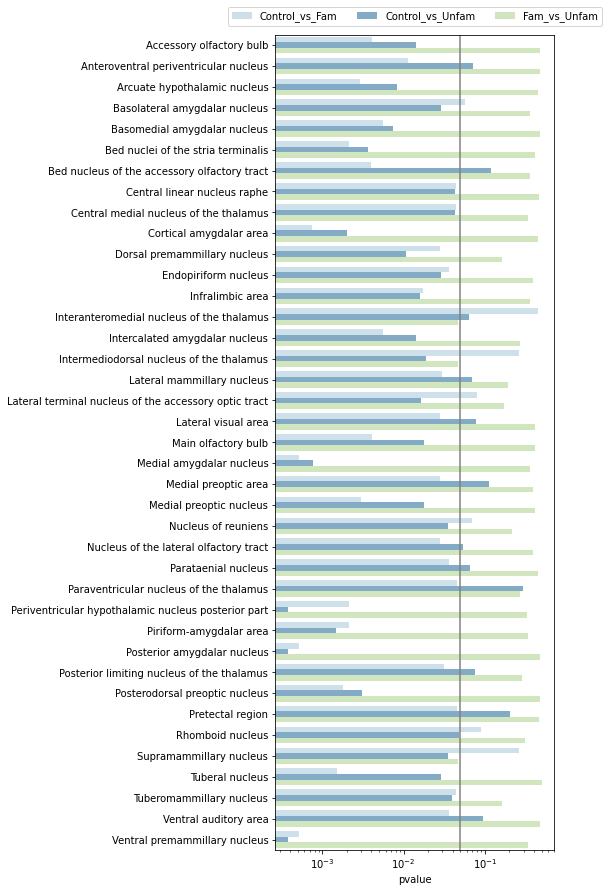

In [179]:
fig, ax = plt.subplots(1,1, figsize=(5,15))
sns.barplot(
    data=df1,
    y="area", x="pvalue", hue="group", alpha=.6,
    axes=ax, palette='Paired')
ax.set_xscale("log")
ax.set_ylabel('')
ax.axvline(x=0.05, color='grey')
ax.legend(
loc='upper center', 
bbox_to_anchor=(0.5, 1.04),
ncol=3)

# Plot singole aree

In [ ]:
dfs = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dict_results_across_mice, 
                              value=value)
df_ttest = ace.test_across_groups(dfs,
                                 test=test,
                                 groups=list(experimental_groups.keys()))
columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
find_common_areas = np.unique(np.concatenate([
    df_ttest[df_ttest[col]<alpha]['area'].to_numpy() \
    for col in df_ttest.loc[:, df_ttest.columns!='area'].columns]).ravel())

df_ttest = df_ttest.set_index('area').loc[find_common_areas]
df_ttest.columns = [col.replace('pval_', '') for col in columns if col!='area']
df_ttest = df_ttest.reset_index()
